#**Load Data**

In [2]:
import pandas as pd

df = pd.read_csv('stemmed_tweets.csv', encoding='ISO-8859-1')

df.head(10)

,Tweet,HS,stemmed_tweet
0,disaat semua cowok berusaha melacak perhatian ...,1,saat semua cowok usaha lacak perhatiangue loe ...
1,siapa yang telat ngasih tau eluedan sarap gue ...,0,siapa yang telat ngasih tau eluedan sarap gue ...
2,kadang aku berfikir kenapa aku tetap percaya ...,0,kadang aku berfikir kenapa aku tetap percaya p...
3,aku itu akunnku tau matamu sipit tapi diliat d...,0,aku itu akunnku tau mata sipit tapi liat dari ...
4,kaum cebong kapir udah keliatan dongoknya dari...,1,kaum cebong kapir udah liat dongok dari awal t...
5,ya bani taplak dkk,1,ya bani taplak dkk
6,deklarasi pilkada aman dan anti hoax warga du...,0,deklarasi pilkada aman dan anti hoax warga duk...
7,gue baru aja kelar rewatch aldnoah zero paling...,0,gue baru aja kelar rewatch aldnoah zero paling...
8,nah admin belanja satu lagi poterbaik nak maka...,0,nah admin belanja satu lagi poterbaik nak maka...
9,enak lg klo smbil ngewe,0,enak lg klo smbil ngewe


In [3]:
df = df.dropna(subset=['stemmed_tweet'])
df.isna().sum()

Tweet            0
HS               0
stemmed_tweet    0
dtype: int64

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Make sure to download these resources if you haven't already
nltk.download('stopwords')
nltk.download('punkt')

# Load Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')


# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in indonesian_stopwords]
    return ' '.join(filtered_words)

# Apply the function to each tweet
df['no_stopwords'] = df['stemmed_tweet'].apply(remove_stopwords)

# Display the first 10 rows of the DataFrame to check the result
print(df.head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                               Tweet  HS  \
0  disaat semua cowok berusaha melacak perhatian ...   1   
1  siapa yang telat ngasih tau eluedan sarap gue ...   0   
2   kadang aku berfikir kenapa aku tetap percaya ...   0   
3  aku itu akunnku tau matamu sipit tapi diliat d...   0   
4  kaum cebong kapir udah keliatan dongoknya dari...   1   
5                                ya bani taplak dkk    1   
6  deklarasi pilkada  aman dan anti hoax warga du...   0   
7  gue baru aja kelar rewatch aldnoah zero paling...   0   
8  nah admin belanja satu lagi poterbaik nak maka...   0   
9                            enak lg klo smbil ngewe   0   

                                       stemmed_tweet  \
0  saat semua cowok usaha lacak perhatiangue loe ...   
1  siapa yang telat ngasih tau eluedan sarap gue ...   
2  kadang aku berfikir kenapa aku tetap percaya p...   
3  aku itu akunnku tau mata sipit tapi liat dari ...   
4  kaum cebong kapir udah liat dongok dari awal t...   
5  

In [9]:
# Saving the DataFrame to a CSV file
df.to_csv('final_Process_Tweet.csv', index=False, encoding='utf-8')


In [8]:
df[['HS', 'no_stopwords']]

,HS,no_stopwords
0,1,cowok usaha lacak perhatiangue loe lantas reme...
1,0,telat ngasih tau eluedan sarap gue gaul cigax ...
2,0,kadang berfikir percaya tuhan jatuh berkalikal...
3,0,akunnku tau mata sipit liat
4,1,kaum cebong kapir udah liat dongok dongok hahahah
...,...,...
13131,1,cina antek aseng emang suka bikin rusak negara...
13132,1,mikir ga banyakan orang biadab orang islam
13133,1,goblok banget nih orang udah tau salah playing...
13134,1,orang orang kayak gini nih pantes mati gedek b...


#**indobertweet-bilstm-cnn**

In [26]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(64, return_sequences=True)))
model_combined.add(Dropout(0.5))
#model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D())
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np

# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 768)          24516864  
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 256)          918528    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 100, 256)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 48, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 64)          

In [25]:
# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

83/83 [==============================] - 18s 210ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8455    0.8882    0.8663      1503
           1     0.8394    0.7825    0.8100      1122

    accuracy                         0.8430      2625
   macro avg     0.8424    0.8354    0.8381      2625
weighted avg     0.8429    0.8430    0.8422      2625



In [ ]:
model_combined.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('trained_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.shape

(13219, 2)

#**BiLSTM**

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(df['no_stopwords'], df['HS'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

# Vektorisasi teks dengan Tokenizer dan pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_vect = pad_sequences(X_train_seq, maxlen=100)  # Sesuaikan maxlen sesuai kebutuhan

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_vect = pad_sequences(X_val_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_vect = pad_sequences(X_test_seq, maxlen=100)

# Pembuatan model
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, trainable=True))
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm.add(GlobalMaxPooling1D())
model_bilstm.add(Dense(1, activation='sigmoid'))

# Kompilasi model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Pelatihan model
history = model_bilstm.fit(X_train_vect, y_train, epochs=5, batch_size=16, validation_data=(X_val_vect, y_val), verbose=1)

# Prediksi
y_pred = model_bilstm.predict(X_test_vect)
y_pred_labels = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_labels, target_names=['Negative', 'Positive'], digits=4)
print(report)




Epoch 1/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 57s 97ms/step - accuracy: 0.6899 - loss: 0.5535 - val_accuracy: 0.8519 - val_loss: 0.3165
Epoch 2/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step - accuracy: 0.9325 - loss: 0.1771 - val_accuracy: 0.8438 - val_loss: 0.3538
Epoch 3/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.9717 - loss: 0.0839 - val_accuracy: 0.8371 - val_loss: 0.4731
Epoch 4/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 51s 97ms/step - accuracy: 0.9853 - loss: 0.0439 - val_accuracy: 0.8376 - val_loss: 0.5618
Epoch 5/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.9908 - loss: 0.0259 - val_accuracy: 0.8348 - val_loss: 0.6301
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
              precision    recall  f1-score   support

    Negative     0.8367    0.8523    0.8444      1503
    Positive     0.7971    0.7772    0.7870      1122

    accuracy                         0.8202      2625
   macro avg     0.8169    0.8147    0.8157      2625
weighted avg     0.8198    0.8202    0.819

#**cnn**

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(df['no_stopwords'], df['HS'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Vektorisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_vect = pad_sequences(X_train_seq, maxlen=100)  # Sesuaikan maxlen sesuai kebutuhan

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_vect = pad_sequences(X_val_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_vect = pad_sequences(X_test_seq, maxlen=100)

# Pembuatan model CNN
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, trainable=True))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(MaxPooling1D(5))
model_cnn.add(Conv1D(64, 3, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))

# Kompilasi model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Pelatihan model
history = model_cnn.fit(X_train_vect, y_train, epochs=5, batch_size=16, validation_data=(X_val_vect, y_val), verbose=1)

# Prediksi
y_pred = model_cnn.predict(X_test_vect)
y_pred_labels = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_labels, target_names=['Negative', 'Positive'])
print(report)


Epoch 1/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6810 - loss: 0.5561 - val_accuracy: 0.8004 - val_loss: 0.4166
Epoch 2/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9163 - loss: 0.2152 - val_accuracy: 0.8095 - val_loss: 0.4566
Epoch 3/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9690 - loss: 0.0767 - val_accuracy: 0.8156 - val_loss: 0.6072
Epoch 4/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9843 - loss: 0.0385 - val_accuracy: 0.8076 - val_loss: 0.7037
Epoch 5/5
493/493 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9896 - loss: 0.0237 - val_accuracy: 0.8069 - val_loss: 0.8833
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

    Negative       0.81      0.84      0.82      1503
    Positive       0.77      0.74      0.75      1122

    accuracy                           0.79      2625
   macro avg       0.79      0.79      0.79      2625
weighted avg       0.79      0.79      0.79 

In [47]:
# Prediksi
y_pred = model_cnn.predict(X_test_vect)
y_pred_labels = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_labels, target_names=['Negative', 'Positive'], digits=4)
print(report)

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

    Negative     0.8095    0.8370    0.8230      1503
    Positive     0.7712    0.7362    0.7533      1122

    accuracy                         0.7939      2625
   macro avg     0.7904    0.7866    0.7882      2625
weighted avg     0.7932    0.7939    0.7932      2625



#**bilstm-cnn**

In [55]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, Dropout, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(df['no_stopwords'], df['HS'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)  # 0.25 x 0.8 = 0.2

# Vektorisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_vect = pad_sequences(X_train_seq, maxlen=100)  # Sesuaikan maxlen sesuai kebutuhan

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_vect = pad_sequences(X_val_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_vect = pad_sequences(X_test_seq, maxlen=100)

# Pembuatan model CNN
model_bilstm_cnn = Sequential()
model_bilstm_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, trainable=True))
model_bilstm_cnn.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm_cnn.add(Conv1D(128, 5, activation='relu'))
model_bilstm_cnn.add(MaxPooling1D(2))
model_bilstm_cnn.add(Conv1D(64, 3, activation='relu'))
model_bilstm_cnn.add(GlobalMaxPooling1D())
model_bilstm_cnn.add(Dense(1, activation='sigmoid'))

# Kompilasi model
model_bilstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Pelatihan model
history = model_bilstm_cnn.fit(X_train_vect, y_train, epochs=5, batch_size=16, validation_data=(X_val_vect, y_val), verbose=1)

# Prediksi
y_pred = model_bilstm_cnn.predict(X_test_vect)
y_pred_labels = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_labels, target_names=['Negative', 'Positive'], digits=4)
print(report)


Epoch 1/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.7120 - loss: 0.5198 - val_accuracy: 0.8519 - val_loss: 0.3436
Epoch 2/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 59s 112ms/step - accuracy: 0.9324 - loss: 0.1667 - val_accuracy: 0.8305 - val_loss: 0.4413
Epoch 3/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - accuracy: 0.9688 - loss: 0.0845 - val_accuracy: 0.8319 - val_loss: 0.5167
Epoch 4/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 58s 110ms/step - accuracy: 0.9822 - loss: 0.0460 - val_accuracy: 0.8252 - val_loss: 0.7706
Epoch 5/5
525/525 ━━━━━━━━━━━━━━━━━━━━ 58s 111ms/step - accuracy: 0.9894 - loss: 0.0281 - val_accuracy: 0.8224 - val_loss: 0.9562
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
              precision    recall  f1-score   support

    Negative     0.8342    0.8270    0.8306      1503
    Positive     0.7709    0.7799    0.7754      1122

    accuracy                         0.8069      2625
   macro avg     0.8026    0.8034    0.8030      2625
weighted avg     0.8072    0.8069    0

In [2]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Assuming df is loaded and prepared
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define the improved model
indobertwwet = Sequential()
hidden_size = model_indobertweet.config.hidden_size
indobertwwet.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
indobertwwet.add(Flatten())  # Flatten the output of the embedding to collapse the sequence dimension
indobertwwet.add(Dense(128, activation='relu'))
indobertwwet.add(Dense(128, activation='relu'))
indobertwwet.add(Dense(128, activation='relu'))
indobertwwet.add(Dense(128, activation='relu'))
indobertwwet.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
indobertwwet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
indobertwwet.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
indobertwwet.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions
y_pred = indobertwwet.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 111s 164ms/step - accuracy: 0.5582 - loss: 0.7020 - val_accuracy: 0.5800 - val_loss: 0.6687
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 105s 160ms/step - accuracy: 0.5749 - loss: 0.6626 - val_accuracy: 0.6890 - val_loss: 0.6021
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 102s 156ms/step - accuracy: 0.5810 - loss: 0.6614 - val_accuracy: 0.5800 - val_loss: 0.6805
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 141s 154ms/step - accuracy: 0.5836 - loss: 0.6796 - val_accuracy: 0.5800 - val_loss: 0.6822
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - accuracy: 0.5740 - loss: 0.6827 - val_accuracy: 0.5800 - val_loss: 0.6804
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.6609    0.9527    0.7804      1522
           1     0.8326    0.3249    0.4674      1102

    accuracy                         0.6890      2624
   macro avg     0.7467    0.6388    0.6239      2624


In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf

# Load and prepare data
df = pd.read_csv('final_Process_Tweet.csv')
df.dropna(subset=['no_stopwords'], inplace=True)  # Drop rows with NaN in 'no_stopwords'
df['no_stopwords'] = df['no_stopwords'].astype(str)  # Ensure all data are strings

# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding='max_length', truncation=True, max_length=max_len, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define the model with Multihead Attention
def create_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    
    # Using the transformer model's output
    outputs = model_indobertweet(input_ids=input_ids)
    sequence_output = outputs[0]  # Get the last hidden state

    # Multihead Attention
    attn_output = MultiHeadAttention(num_heads=2, key_dim=model_indobertweet.config.hidden_size)(sequence_output, sequence_output)
    x = LayerNormalization(epsilon=1e-6)(sequence_output + attn_output)

    # Feed Forward Network
    ff_output = Dense(model_indobertweet.config.hidden_size, activation='relu')(x)
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Mean pooling
    x = tf.reduce_mean(x, axis=1)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids], outputs=[output])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
indobertweet_enhanced = create_model()
indobertweet_enhanced.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
indobertweet_enhanced.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions
y_pred = indobertweet_enhanced.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining mod

ValueError: Exception encountered when calling layer 'tf_bert_model' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model' (type TFBertModel):
  • input_ids=<KerasTensor shape=(None, 100), dtype=int32, sparse=None, name=input_ids>
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

#**indobertwwet-bilstm**

In [34]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define the improved model using the name 'model_indobertweet_bilstm'
model_indobertweet_bilstm = Sequential()
model_indobertweet_bilstm.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=model_indobertweet.config.hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_indobertweet_bilstm.add(Bidirectional(LSTM(64, return_sequences=False)))
model_indobertweet_bilstm.add(Dense(1, activation='sigmoid'))


model_indobertweet_bilstm.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_indobertweet_bilstm.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model_indobertweet_bilstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report


# Predictions
y_pred = model_indobertweet_bilstm.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 93s 130ms/step - accuracy: 0.6851 - loss: 0.5784 - val_accuracy: 0.8206 - val_loss: 0.4083
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.8336 - loss: 0.3674 - val_accuracy: 0.8430 - val_loss: 0.3507
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.8632 - loss: 0.3124 - val_accuracy: 0.8476 - val_loss: 0.3446
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 83s 118ms/step - accuracy: 0.8803 - loss: 0.2764 - val_accuracy: 0.8446 - val_loss: 0.3671
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.9045 - loss: 0.2287 - val_accuracy: 0.8450 - val_loss: 0.3610
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.9257 - loss: 0.1910 - val_accuracy: 0.8430 - val_loss: 0.3832
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8621    0.8736    0.8678      1503
           1     0.8276    0.8128    0.820

#**indobertweet-cnn**

In [39]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['stemmed_tweet'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define the model using the name 'model_indobertweet_cnn'
model_indobertweet_cnn = Sequential()
model_indobertweet_cnn.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=model_indobertweet.config.hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_indobertweet_cnn.add(Conv1D(128, kernel_size=5, activation='relu', padding='valid'))
model_indobertweet_cnn.add(MaxPooling1D(2))
model_indobertweet_cnn.add(Conv1D(64, kernel_size=3, activation='relu', padding='valid'))
model_indobertweet_cnn.add(GlobalMaxPooling1D())
#model_indobertweet_cnn.add(Dense(128, activation='relu'))

#model_indobertweet_cnn.add(Dropout(0.5))
#model_indobertweet_cnn.add(Dense(64, activation='relu'))
model_indobertweet_cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_indobertweet_cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_indobertweet_cnn.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model_indobertweet_cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Predictions
y_pred = model_indobertweet_cnn.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)




Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_37 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.7242 - loss: 0.5286 - val_accuracy: 0.8076 - val_loss: 0.4254
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.9093 - loss: 0.2325 - val_accuracy: 0.8385 - val_loss: 0.3671
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.9712 - loss: 0.0937 - val_accuracy: 0.8446 - val_loss: 0.4622
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.9891 - loss: 0.0401 - val_accuracy: 0.8427 - val_loss: 0.5486
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9956 - loss: 0.0200 - val_accuracy: 0.8381 - val_loss: 0.6778
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9172    0.7891    0.8484      1503
           1     0.7620    0.9046    0.8272      1122

    accuracy                         0.8385      2625
   macro avg     0.8396    0.8469    0.8378      2625
weighted avg   

#**Batch Size and Learningrate Experient**

In [17]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define a range of learning rates and batch sizes to experiment with
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [10, 16, 32, 64]

# Create a table to store val_accuracy results
val_accuracy_table = pd.DataFrame(index=batch_sizes, columns=[f"lr {lr}" for lr in learning_rates])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Loop through learning rates
for lr in learning_rates:
    # Loop through batch sizes
    for batch_size in batch_sizes:
        # Create and compile the model with specified learning rate and batch size
        model_combined = Sequential()
        hidden_size = model_indobertweet.config.hidden_size
        model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
        model_combined.add(Bidirectional(LSTM(128, return_sequences=True)))
        model_combined.add(Dropout(0.5))
        model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
        model_combined.add(MaxPooling1D(pool_size=2))
        model_combined.add(Flatten())
        model_combined.add(Dense(1, activation='sigmoid'))
        
        optimizer = Adam(learning_rate=lr)
        model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model_combined.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

        # Save val_accuracy in the table
        val_accuracy_table.loc[batch_size, f"lr {lr}"] = history.history['val_accuracy'][-1]

# Display the val_accuracy table
print(val_accuracy_table)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 316s 297ms/step - accuracy: 0.6901 - loss: 0.5669 - val_accuracy: 0.8400 - val_loss: 0.3650
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 282s 269ms/step - accuracy: 0.8405 - loss: 0.3496 - val_accuracy: 0.8404 - val_loss: 0.3643
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 268s 255ms/step - accuracy: 0.8739 - loss: 0.2921 - val_accuracy: 0.8453 - val_loss: 0.3592
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 282s 268ms/step - accuracy: 0.9018 - loss: 0.2372 - val_accuracy: 0.8389 - val_loss: 0.3729
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 311s 296ms/step - accuracy: 0.9236 - loss: 0.1862 - val_accuracy: 0.8217 - val_loss: 0.5380
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 295s 281ms/step - accuracy: 0.9492 - loss: 0.1270 - val_accuracy: 0.8408 - val_loss: 0.4397
Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 246s 357ms/step - accuracy: 0.6547 - loss: 0.5961 - val_accuracy: 0.7741 - val_loss: 0.4915
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 219s 333ms/step - accura

In [18]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define a range of learning rates and batch sizes to experiment with
learning_rates = [0.001]
batch_sizes = [9, 8, 7, 6, 5]

# Create a table to store val_accuracy results
val_accuracy_table = pd.DataFrame(index=batch_sizes, columns=[f"lr {lr}" for lr in learning_rates])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Loop through learning rates
for lr in learning_rates:
    # Loop through batch sizes
    for batch_size in batch_sizes:
        # Create and compile the model with specified learning rate and batch size
        model_combined = Sequential()
        hidden_size = model_indobertweet.config.hidden_size
        model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
        model_combined.add(Bidirectional(LSTM(128, return_sequences=True)))
        model_combined.add(Dropout(0.5))
        model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
        model_combined.add(MaxPooling1D(pool_size=2))
        model_combined.add(Flatten())
        model_combined.add(Dense(1, activation='sigmoid'))
        
        optimizer = Adam(learning_rate=lr)
        model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model_combined.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

        # Save val_accuracy in the table
        val_accuracy_table.loc[batch_size, f"lr {lr}"] = history.history['val_accuracy'][-1]

# Display the val_accuracy table
print(val_accuracy_table)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Epoch 1/50
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 375s 318ms/step - accuracy: 0.6717 - loss: 0.5759 - val_accuracy: 0.8293 - val_loss: 0.3681
Epoch 2/50
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 370s 317ms/step - accuracy: 0.8462 - loss: 0.3487 - val_accuracy: 0.8457 - val_loss: 0.3503
Epoch 3/50
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 335s 287ms/step - accuracy: 0.8768 - loss: 0.2828 - val_accuracy: 0.8480 - val_loss: 0.3572
Epoch 4/50
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 322s 276ms/step - accuracy: 0.8970 - loss: 0.2479 - val_accuracy: 0.8472 - val_loss: 0.3670
Epoch 5/50
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 313s 268ms/step - accuracy: 0.9259 - loss: 0.1802 - val_accuracy: 0.8469 - val_loss: 0.3870
Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 345s 257ms/step - accuracy: 0.6847 - loss: 0.5704 - val_accuracy: 0.8335 - val_loss: 0.3674
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 349s 265ms/step - accuracy: 0.8587 - loss: 0.3324 - val_accuracy: 0.8396 - val_loss: 0.3594
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 343s 261ms/step - ac

#**Final Model**

In [26]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(64, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(32, kernel_size=5, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 55s 151ms/step - accuracy: 0.6127 - loss: 0.6392 - val_accuracy: 0.8179 - val_loss: 0.4066
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8212 - loss: 0.3989 - val_accuracy: 0.8202 - val_loss: 0.3936
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.8503 - loss: 0.3386 - val_accuracy: 0.8343 - val_loss: 0.3646
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 49s 149ms/step - accuracy: 0.8718 - loss: 0.2985 - val_accuracy: 0.8495 - val_loss: 0.3456
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.8907 - loss: 0.2598 - val_accuracy: 0.8385 - val_loss: 0.3813
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.9017 - loss: 0.2315 - val_accuracy: 0.8457 - val_loss: 0.3674
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.9211 - loss: 0.1964 - val_accuracy: 0.8446 - val_loss: 0.3774
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
Classification Report:
              precis

In [33]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(64, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.6514 - loss: 0.6051 - val_accuracy: 0.8293 - val_loss: 0.3921
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 75s 113ms/step - accuracy: 0.8403 - loss: 0.3583 - val_accuracy: 0.8385 - val_loss: 0.3595
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.8647 - loss: 0.3039 - val_accuracy: 0.8392 - val_loss: 0.3538
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - accuracy: 0.8788 - loss: 0.2783 - val_accuracy: 0.8507 - val_loss: 0.3519
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.9025 - loss: 0.2319 - val_accuracy: 0.8438 - val_loss: 0.3781
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 76s 116ms/step - accuracy: 0.9175 - loss: 0.1941 - val_accuracy: 0.8358 - val_loss: 0.4497
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 77s 117ms/step - accuracy: 0.9393 - loss: 0.1542 - val_accuracy: 0.8267 - val_loss: 0.5237
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
Classification Report:
              precis

In [15]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(128, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 258s 379ms/step - accuracy: 0.6229 - loss: 0.6283 - val_accuracy: 0.8194 - val_loss: 0.3856
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 235s 357ms/step - accuracy: 0.8442 - loss: 0.3468 - val_accuracy: 0.8370 - val_loss: 0.3612
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 211s 321ms/step - accuracy: 0.8701 - loss: 0.3023 - val_accuracy: 0.8499 - val_loss: 0.3433
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 181s 276ms/step - accuracy: 0.8932 - loss: 0.2523 - val_accuracy: 0.8434 - val_loss: 0.3676
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 182s 276ms/step - accuracy: 0.9089 - loss: 0.2156 - val_accuracy: 0.8373 - val_loss: 0.3799
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 191s 291ms/step - accuracy: 0.9309 - loss: 0.1647 - val_accuracy: 0.8385 - val_loss: 0.5172
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8679    0.8703    0.8691      1503
           1     0.8256    0.8226   

In [22]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(128, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_40                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 269s 398ms/step - accuracy: 0.6848 - loss: 0.5731 - val_accuracy: 0.8229 - val_loss: 0.3860
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 247s 376ms/step - accuracy: 0.8443 - loss: 0.3521 - val_accuracy: 0.8354 - val_loss: 0.3569
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 259s 394ms/step - accuracy: 0.8736 - loss: 0.2966 - val_accuracy: 0.8453 - val_loss: 0.3514
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 254s 387ms/step - accuracy: 0.8908 - loss: 0.2572 - val_accuracy: 0.8545 - val_loss: 0.3473
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 230s 350ms/step - accuracy: 0.9105 - loss: 0.2111 - val_accuracy: 0.8427 - val_loss: 0.4259
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 271s 413ms/step - accuracy: 0.9360 - loss: 0.1680 - val_accuracy: 0.8404 - val_loss: 0.4156
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 268s 408ms/step - accuracy: 0.9561 - loss: 0.1144 - val_accuracy: 0.8381 - val_loss: 0.5465
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step
Classification Report:
           

In [23]:
# Save the model
model_combined.save('model_final.h5')

In [6]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(128, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=3))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
history = model_combined.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 298s 280ms/step - accuracy: 0.6429 - loss: 0.6052 - val_accuracy: 0.8244 - val_loss: 0.3911
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 352s 335ms/step - accuracy: 0.8402 - loss: 0.3477 - val_accuracy: 0.8427 - val_loss: 0.3527
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 305s 290ms/step - accuracy: 0.8674 - loss: 0.3050 - val_accuracy: 0.8419 - val_loss: 0.3827
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 299s 285ms/step - accuracy: 0.8896 - loss: 0.2597 - val_accuracy: 0.8430 - val_loss: 0.3505
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 221s 210ms/step - accuracy: 0.9058 - loss: 0.2213 - val_accuracy: 0.8415 - val_loss: 0.4294
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 215s 204ms/step - accuracy: 0.9311 - loss: 0.1632 - val_accuracy: 0.8301 - val_loss: 0.4869
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 214s 204ms/step - accuracy: 0.9505 - loss: 0.1318 - val_accuracy: 0.8324 - val_loss: 0.5385
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step
Classification Repor

In [14]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Tokenization using IndoBERTweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load IndoBERTweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)

# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Define the RNN model using the name 'model_rnn'
model_rnn = Sequential()
hidden_size = model_indobertweet.config.hidden_size
model_rnn.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_rnn.add(LSTM(128, return_sequences=False))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_rnn.summary()

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_rnn = model_rnn.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predictions
y_pred_rnn = model_rnn.predict(X_test)
y_pred_classes_rnn = np.round(y_pred_rnn)

# Classification Report
class_report_rnn = classification_report(y_test, y_pred_classes_rnn, digits=4)
print("Classification Report for RNN Model:")
print(class_report_rnn)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 119s 111ms/step - accuracy: 0.5644 - loss: 0.6913 - val_accuracy: 0.5726 - val_loss: 0.6826
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 124s 118ms/step - accuracy: 0.5730 - loss: 0.6836 - val_accuracy: 0.5726 - val_loss: 0.6829
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 128s 122ms/step - accuracy: 0.5769 - loss: 0.6830 - val_accuracy: 0.5726 - val_loss: 0.6826
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 111s 106ms/step - accuracy: 0.5781 - loss: 0.6824 - val_accuracy: 0.5726 - val_loss: 0.6826
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 133s 126ms/step - accuracy: 0.5765 - loss: 0.6827 - val_accuracy: 0.5726 - val_loss: 0.6826
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 143s 136ms/step - accuracy: 0.5808 - loss: 0.6813 - val_accuracy: 0.5726 - val_loss: 0.6829
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 136s 130ms/step - accuracy: 0.5851 - loss: 0.6794 - val_accuracy: 0.5726 - val_loss: 0.6837
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


NameError: name 'np' is not defined

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

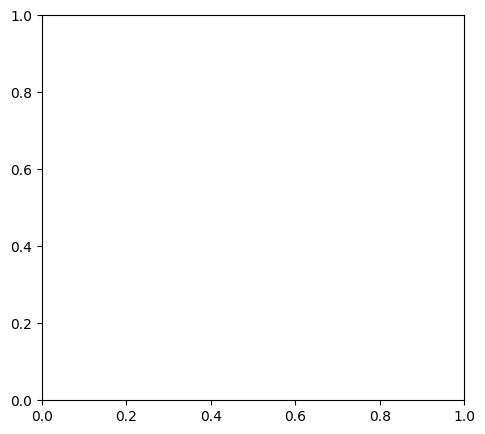

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # Jika Anda menggunakan TensorFlow untuk pelatihan model

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.lineplot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss')
sns.lineplot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.lineplot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train Accuracy')
sns.lineplot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)



# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined8 = Sequential()
model_combined8.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined8.add(Bidirectional(LSTM(128, return_sequences=True)))
model_combined8.add(Dropout(0.5))
model_combined8.add(Conv1D(128, kernel_size=5, padding='valid', activation='relu'))
model_combined8.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined8.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined8.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined8.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined8.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined8.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined8.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_43                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 330s 247ms/step - accuracy: 0.6987 - loss: 0.5557 - val_accuracy: 0.8217 - val_loss: 0.3927
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 324s 247ms/step - accuracy: 0.8465 - loss: 0.3438 - val_accuracy: 0.8465 - val_loss: 0.3484
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 334s 254ms/step - accuracy: 0.8720 - loss: 0.2945 - val_accuracy: 0.8430 - val_loss: 0.3658
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 359s 274ms/step - accuracy: 0.8917 - loss: 0.2522 - val_accuracy: 0.8373 - val_loss: 0.3699
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 312s 238ms/step - accuracy: 0.9212 - loss: 0.1881 - val_accuracy: 0.8476 - val_loss: 0.4166
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.8387    0.9062    0.8711      1503
           1     0.8591    0.7665    0.8102      1122

    accuracy                         0.8465      2625
   macro avg     0.8489    0.8363    0.8406    

In [16]:
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Tokenization using Indobertweet tokenizer
max_len = 100
tokenizer_indobertweet = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
sequences_indobertweet = tokenizer_indobertweet(df['no_stopwords'].tolist(), padding=True, truncation=True, return_tensors="tf")
X_indobertweet = pad_sequences(sequences_indobertweet['input_ids'], maxlen=max_len, padding='post')

# Load Indobertweet model with from_pt=True
model_indobertweet = TFAutoModel.from_pretrained("indolem/indobertweet-base-uncased", from_pt=True)


# Label Encoding
le = LabelEncoder()
df['HS'] = le.fit_transform(df['HS'])
y = df['HS'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_indobertweet, y, test_size=0.2, random_state=42)

# Replace the feedforward layer with BiLSTM and CNN layers
model_combined = Sequential()

# Get the hidden size directly from the model
hidden_size = model_indobertweet.config.hidden_size


# Define the improved model using the name 'model_combined'
model_combined = Sequential()
model_combined.add(Embedding(input_dim=tokenizer_indobertweet.vocab_size, output_dim=hidden_size, input_length=max_len, weights=[model_indobertweet.get_weights()[0]], trainable=False))
model_combined.add(Bidirectional(LSTM(64, return_sequences=True)))
model_combined.add(Dropout(0.5))
model_combined.add(Conv1D(64, kernel_size=3, padding='valid', activation='relu'))
model_combined.add(MaxPooling1D(pool_size=2))
#model_combined.add(Conv1D(32, kernel_size=3, padding='valid', activation='relu'))
#model_combined.add(MaxPooling1D(pool_size=2))
model_combined.add(Flatten())
#model_combined.add(Dense(128, activation='relu'))
#model_combined.add(Dropout(0.5))
#model_combined.add(Dense(64, activation='relu'))
model_combined.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_combined.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_combined.summary()



# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Train the model
model_combined.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

from sklearn.metrics import classification_report
import numpy as np


# Predictions
y_pred = model_combined.predict(X_test)
y_pred_classes = np.round(y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from t

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │    24,516,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,516,864 (93.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,516,864 (93.52 MB)

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 139s 197ms/step - accuracy: 0.6403 - loss: 0.6102 - val_accuracy: 0.8301 - val_loss: 0.3939
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - accuracy: 0.8439 - loss: 0.3518 - val_accuracy: 0.8366 - val_loss: 0.3611
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 90s 137ms/step - accuracy: 0.8717 - loss: 0.3024 - val_accuracy: 0.8225 - val_loss: 0.3980
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - accuracy: 0.8826 - loss: 0.2779 - val_accuracy: 0.8495 - val_loss: 0.3585
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 105s 159ms/step - accuracy: 0.9024 - loss: 0.2404 - val_accuracy: 0.8404 - val_loss: 0.4141
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.9186 - loss: 0.1950 - val_accuracy: 0.8350 - val_loss: 0.3873
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 91s 139ms/step - accuracy: 0.9444 - loss: 0.1424 - val_accuracy: 0.8442 - val_loss: 0.4307
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
Classification Report:
              pre

#**Simple Test**

In [ ]:
from tensorflow.keras.models import load_model
from transformers import AutoTokenizer
import numpy as np

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

# Load the model
model = model_combined#load_model('trained_model.h5')  # Make sure the model path is correct

def detect_hate_speech(text):
    # Tokenize and prepare the input text
    max_len = 100
    tokens = tokenizer.encode_plus(text, max_length=max_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    input_ids = tokens['input_ids']

    # Make a prediction
    prediction = model.predict(input_ids)[0]

    # Determine the class based on the model's prediction
    hate_speech_probability = prediction[0]
    if hate_speech_probability > 0.5:
        result = "Hate Speech Detected"
    else:
        result = "Not Hate Speech"

    return result

# Example use
while True:
    text = input("Teks : ")
    result = detect_hate_speech(text)
    print(f"Detection Result: {result}")
    lanjut = input("input lagi? y/n : ")
    if lanjut == "y":
        True
    else:
        break

1/1 [==============================] - 0s 43ms/step
Detection Result: Not Hate Speech
1/1 [==============================] - 0s 45ms/step
Detection Result: Hate Speech Detected
1/1 [==============================] - 0s 42ms/step
Detection Result: Not Hate Speech
